#1 Clusterização

##1.1 Preliminares

In [147]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium

from folium.plugins import MarkerCluster
from folium.plugins import MousePosition
from folium.features import DivIcon
 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

from google.colab import drive

In [64]:
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)
# pd.set_option("display.max_rows", None)

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [65]:
caminho = '/content/drive/MyDrive/Projeto_Foursquare/'

##1.2 Carregando os dados necessários

Carregando dataframe de trabalho:

In [106]:
df_original = pd.read_csv(caminho + 'categorias_por_bairro.csv')
df = df_original.copy().set_index('bairro_geoloc')
df

,Arts & Entertainment,Colleges & Universities,Events,Food,Outdoors & Recreation,Professional & Other Places,Residences,Shops & Services,Travel & Transport
bairro_geoloc,,,,,,,,,
Aberta dos Morros,0,1,0,3,0,1,1,0,0
Anchieta,0,0,0,6,0,0,3,1,0
Arquipélago,0,1,0,1,0,7,1,0,0
Auxiliadora,0,0,0,8,0,0,1,0,0
Azenha,0,2,0,3,0,0,0,2,0
...,...,...,...,...,...,...,...,...,...
Vila Ipiranga,0,2,0,7,0,2,1,0,0
Vila Jardim,0,3,0,2,0,0,2,0,0
Vila João Pessoa,2,1,0,4,0,1,5,0,0


In [107]:
df.index # Conferindo os bairros (ok) 

Index(['Aberta dos Morros', 'Anchieta', 'Arquipélago', 'Auxiliadora', 'Azenha',
       'Bela Vista', 'Belém Novo', 'Belém Velho', 'Boa Vista',
       'Boa Vista do Sul', 'Bom Fim', 'Bom Jesus', 'Camaquã', 'Campo Novo',
       'Cascata', 'Cavalhada', 'Centro Histórico', 'Chapéu do Sol',
       'Chácara das Pedras', 'Cidade Baixa', 'Coronel Aparício Borges',
       'Costa e Silva', 'Cristal', 'Cristo Redentor', 'Espírito Santo',
       'Extrema', 'Farrapos', 'Farroupilha', 'Floresta', 'Glória', 'Guarujá',
       'Higienópolis', 'Humaitá', 'Hípica', 'Independência', 'Ipanema',
       'Jardim Botânico', 'Jardim Carvalho', 'Jardim Dona Leopoldina',
       'Jardim Europa', 'Jardim Floresta', 'Jardim Isabel', 'Jardim Itu',
       'Jardim Lindóia', 'Jardim Sabará', 'Jardim São Pedro',
       'Jardim do Salso', 'Lageado', 'Lami', 'Lomba do Pinheiro', 'Medianeira',
       'Menino Deus', 'Moinhos de Vento', 'Mont'Serrat', 'Morro Santana',
       'Mário Quintana', 'Navegantes', 'Nonoai', 'Parque S

Carregando dataframe com informações dos bairros:

In [108]:
df_bairros_original = pd.read_csv(caminho + 'tabela2.csv', 
                                  index_col='Unnamed: 0')
df_bairros = df_bairros_original.copy().sort_values('bairro')
df_bairros

,bairro,area,pop2010,densidade,renda,raio,lat,lon,raio_fill
0,Aberta dos Morros,NaN,NaN,NaN,NaN,NaN,-30.160022,-51.197486,1560
1,Agronomia,12410000.0,12222.0,"8,6 hab/ha","3,98 SM/mês",1987.517468,-30.069267,-51.149217,2981
2,Anchieta,840000.0,203.0,"2,4 hab/ha","8,41 SM/mês",517.088295,-29.975652,-51.174903,775
3,Arquipélago,47180000.0,5061.0,"1,1 hab/ha","2,96 SM/mês",1040.130159,-29.992760,-51.226618,1560
4,Auxiliadora,820000.0,9985.0,"121,8 hab/ha","19,57 SM/mês",510.895397,-30.020011,-51.190588,766
...,...,...,...,...,...,...,...,...,...
91,Vila Ipiranga,5200000.0,20951.0,"40,3 hab/ha","8,99 SM/mês",1286.550197,-30.022920,-51.153680,1929
92,Vila Jardim,1780000.0,14251.0,"80,1 hab/ha","5,30 SM/mês",752.722789,-30.035177,-51.153283,1129
93,Vila João Pessoa,840000.0,10522.0,"125,3 hab/ha","5,58 SM/mês",517.088295,-30.065375,-51.176165,775
94,Vila Nova,10310000.0,33145.0,"32,1 hab/ha","5,35 SM/mês",1811.566981,-30.116003,-51.207517,2717


Filtrando apenas os bairros que também estão no dataframe de trabalho (`df`):

In [109]:
df_b2 = df_bairros[df_bairros['bairro'].isin(df.index)]
df_b2 = df_b2.reset_index().drop('index', axis=1)
df_b2

,bairro,area,pop2010,densidade,renda,raio,lat,lon,raio_fill
0,Aberta dos Morros,NaN,NaN,NaN,NaN,NaN,-30.160022,-51.197486,1560
1,Anchieta,840000.0,203.0,"2,4 hab/ha","8,41 SM/mês",517.088295,-29.975652,-51.174903,775
2,Arquipélago,47180000.0,5061.0,"1,1 hab/ha","2,96 SM/mês",1040.130159,-29.992760,-51.226618,1560
3,Auxiliadora,820000.0,9985.0,"121,8 hab/ha","19,57 SM/mês",510.895397,-30.020011,-51.190588,766
4,Azenha,1260000.0,13449.0,"106,7 hab/ha","10,73 SM/mês",633.301237,-30.050721,-51.215607,949
...,...,...,...,...,...,...,...,...,...
88,Vila Ipiranga,5200000.0,20951.0,"40,3 hab/ha","8,99 SM/mês",1286.550197,-30.022920,-51.153680,1929
89,Vila Jardim,1780000.0,14251.0,"80,1 hab/ha","5,30 SM/mês",752.722789,-30.035177,-51.153283,1129
90,Vila João Pessoa,840000.0,10522.0,"125,3 hab/ha","5,58 SM/mês",517.088295,-30.065375,-51.176165,775
91,Vila Nova,10310000.0,33145.0,"32,1 hab/ha","5,35 SM/mês",1811.566981,-30.116003,-51.207517,2717


##1.3 Visualizando os dados

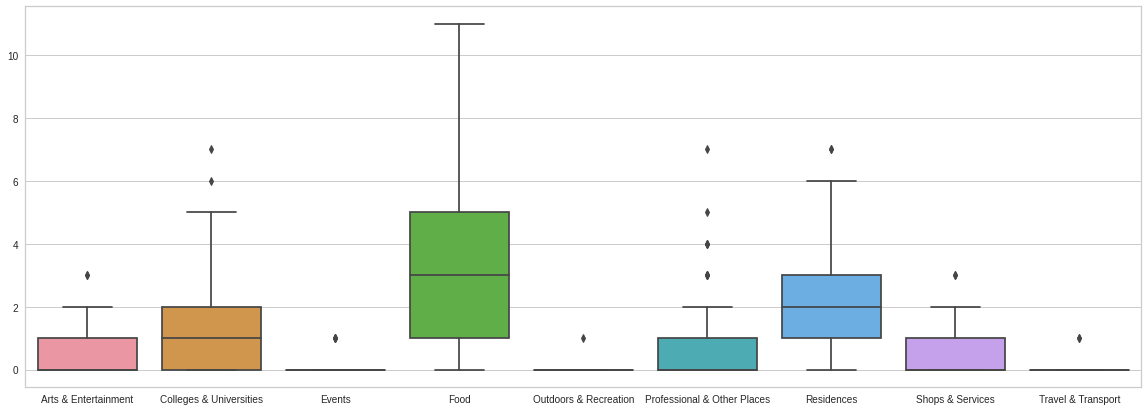

In [142]:
plt.figure(figsize=(20,7))
sns.boxplot(data=df)
plt.show()

In [152]:
df_trans = StandardScaler().fit_transform(df) # StandardScaler() ou MinMaxScaler()
df_trans = pd.DataFrame(df_trans, index=df.index, columns=df.columns)

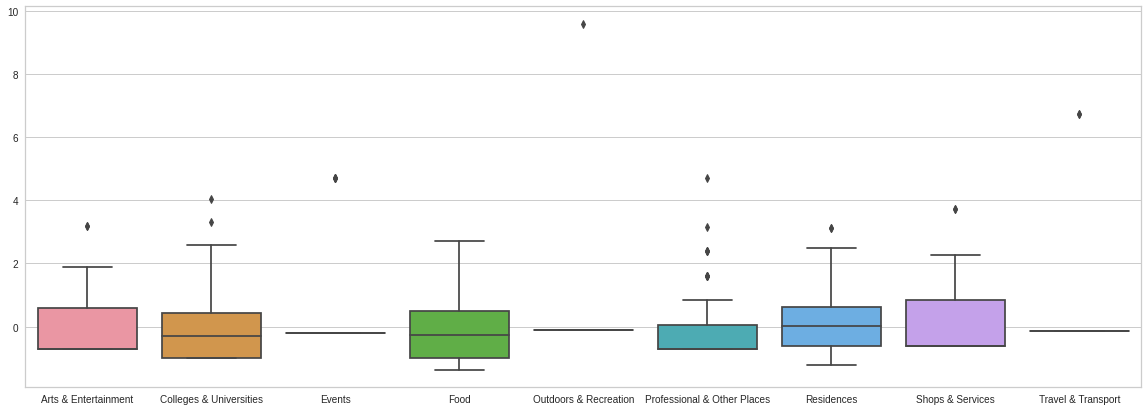

In [153]:
plt.figure(figsize=(20,7))
sns.boxplot(data=df_trans)
plt.show()

##1.4 Modelo KMeans

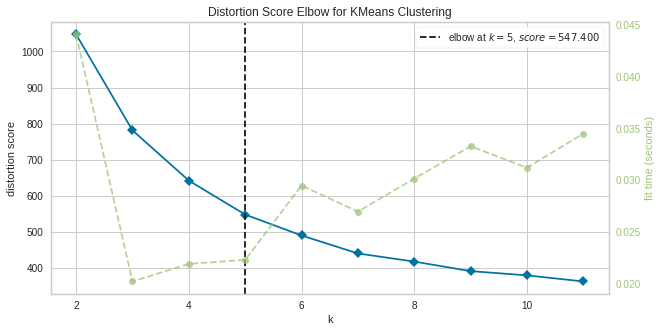

In [166]:
plt.figure(figsize=(10,5))
elbow = KElbowVisualizer(KMeans(random_state=42), k=(2,12))
elbow.fit(df)
elbow.show()

In [167]:
K = 5

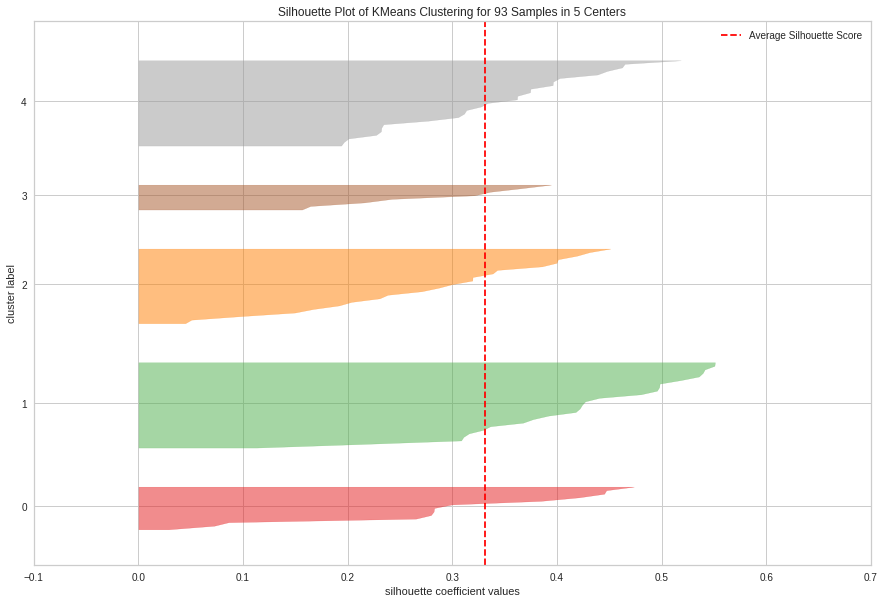

In [189]:
plt.figure(figsize=(15,10))
silhouette = SilhouetteVisualizer(KMeans(K,random_state=42))
silhouette.fit(df) 
silhouette.show()

In [169]:
clusters = KMeans(K,random_state=42).fit_predict(df)
clusters

array([1, 2, 3, 2, 0, 4, 2, 3, 2, 3, 2, 1, 0, 4, 1, 2, 0, 1, 0, 0, 1, 1,
       4, 4, 1, 3, 3, 2, 4, 4, 0, 4, 2, 2, 4, 2, 2, 4, 2, 1, 1, 1, 4, 0,
       4, 4, 1, 1, 3, 4, 1, 0, 4, 4, 4, 1, 0, 4, 1, 2, 0, 1, 4, 4, 1, 1,
       2, 4, 2, 1, 2, 0, 2, 1, 2, 4, 2, 1, 1, 2, 4, 4, 1, 0, 2, 1, 3, 3,
       2, 0, 4, 4, 1], dtype=int32)

In [170]:
df['cluster'] = clusters
df

,Arts & Entertainment,Colleges & Universities,Events,Food,Outdoors & Recreation,Professional & Other Places,Residences,Shops & Services,Travel & Transport,cluster
bairro_geoloc,,,,,,,,,,
Aberta dos Morros,0,1,0,3,0,1,1,0,0,1
Anchieta,0,0,0,6,0,0,3,1,0,2
Arquipélago,0,1,0,1,0,7,1,0,0,3
Auxiliadora,0,0,0,8,0,0,1,0,0,2
Azenha,0,2,0,3,0,0,0,2,0,0
...,...,...,...,...,...,...,...,...,...,...
Vila Ipiranga,0,2,0,7,0,2,1,0,0,2
Vila Jardim,0,3,0,2,0,0,2,0,0,0
Vila João Pessoa,2,1,0,4,0,1,5,0,0,4


In [171]:
dict_clusters = dict(zip(df.index, clusters))
# dict_clusters

In [211]:
df_b2['cluster'] = clusters
df_b2

,bairro,area,pop2010,densidade,renda,raio,lat,lon,raio_fill,cluster,cluster_color
0,Aberta dos Morros,NaN,NaN,NaN,NaN,NaN,-30.160022,-51.197486,1560,1,green
1,Anchieta,840000.0,203.0,"2,4 hab/ha","8,41 SM/mês",517.088295,-29.975652,-51.174903,775,2,red
2,Arquipélago,47180000.0,5061.0,"1,1 hab/ha","2,96 SM/mês",1040.130159,-29.992760,-51.226618,1560,3,brown
3,Auxiliadora,820000.0,9985.0,"121,8 hab/ha","19,57 SM/mês",510.895397,-30.020011,-51.190588,766,2,red
4,Azenha,1260000.0,13449.0,"106,7 hab/ha","10,73 SM/mês",633.301237,-30.050721,-51.215607,949,0,blue
...,...,...,...,...,...,...,...,...,...,...,...
88,Vila Ipiranga,5200000.0,20951.0,"40,3 hab/ha","8,99 SM/mês",1286.550197,-30.022920,-51.153680,1929,2,red
89,Vila Jardim,1780000.0,14251.0,"80,1 hab/ha","5,30 SM/mês",752.722789,-30.035177,-51.153283,1129,0,blue
90,Vila João Pessoa,840000.0,10522.0,"125,3 hab/ha","5,58 SM/mês",517.088295,-30.065375,-51.176165,775,4,purple
91,Vila Nova,10310000.0,33145.0,"32,1 hab/ha","5,35 SM/mês",1811.566981,-30.116003,-51.207517,2717,4,purple


###1.4.1 Visualizando resultado no mapa

In [210]:
list_color = ['blue',
              'green',
              'red',
              'brown',
              'purple',
              'orange']
dict_color = dict(zip(range(0,K), list_color[:K]))
dict_color

{0: 'blue', 1: 'green', 2: 'red', 3: 'brown', 4: 'purple'}

In [183]:
df_b2['cluster_color'] = df_b2['cluster'].map(dict_color)

In [212]:
def add_circ_mark(my_map, my_data):
    for k,row in my_data.iterrows():
        coord = (row['lat'], row['lon'])
        bairro = row['bairro']
        raio = row['raio_fill']
        # marker = folium.Marker(coord, popup=bairro)
        circle = folium.Circle(coord, radius=250, color=row['cluster_color'], fill=True)#color='#d35400'
        my_map.add_child(circle)#.add_child(marker)
    return my_map
coord_poa = (-30.0324999, -51.2303767) 
enter_view = (coord_poa[0]-0.06, coord_poa[1]+0.05)
fig = folium.Figure(width=1000, height=800)
map = folium.Map(location=enter_view, zoom_start=11).add_to(fig)
add_circ_mark(map, df_b2)

###1.4.2 Visualizando resultado com boxplot

In [176]:
df

,Arts & Entertainment,Colleges & Universities,Events,Food,Outdoors & Recreation,Professional & Other Places,Residences,Shops & Services,Travel & Transport,cluster
bairro_geoloc,,,,,,,,,,
Aberta dos Morros,0,1,0,3,0,1,1,0,0,1
Anchieta,0,0,0,6,0,0,3,1,0,2
Arquipélago,0,1,0,1,0,7,1,0,0,3
Auxiliadora,0,0,0,8,0,0,1,0,0,2
Azenha,0,2,0,3,0,0,0,2,0,0
...,...,...,...,...,...,...,...,...,...,...
Vila Ipiranga,0,2,0,7,0,2,1,0,0,2
Vila Jardim,0,3,0,2,0,0,2,0,0,0
Vila João Pessoa,2,1,0,4,0,1,5,0,0,4


In [177]:
df_clusters_tot = df.groupby('cluster').sum()
df_clusters_tot = df_clusters_tot.sort_values('cluster', ascending=True)
df_clusters_tot

,Arts & Entertainment,Colleges & Universities,Events,Food,Outdoors & Recreation,Professional & Other Places,Residences,Shops & Services,Travel & Transport
cluster,,,,,,,,,
0,6,45,0,49,0,5,16,10,0
1,12,18,1,26,0,17,25,11,0
2,13,32,0,166,0,13,39,10,1
3,7,5,1,12,0,32,10,1,0
4,12,30,2,89,1,19,94,7,1


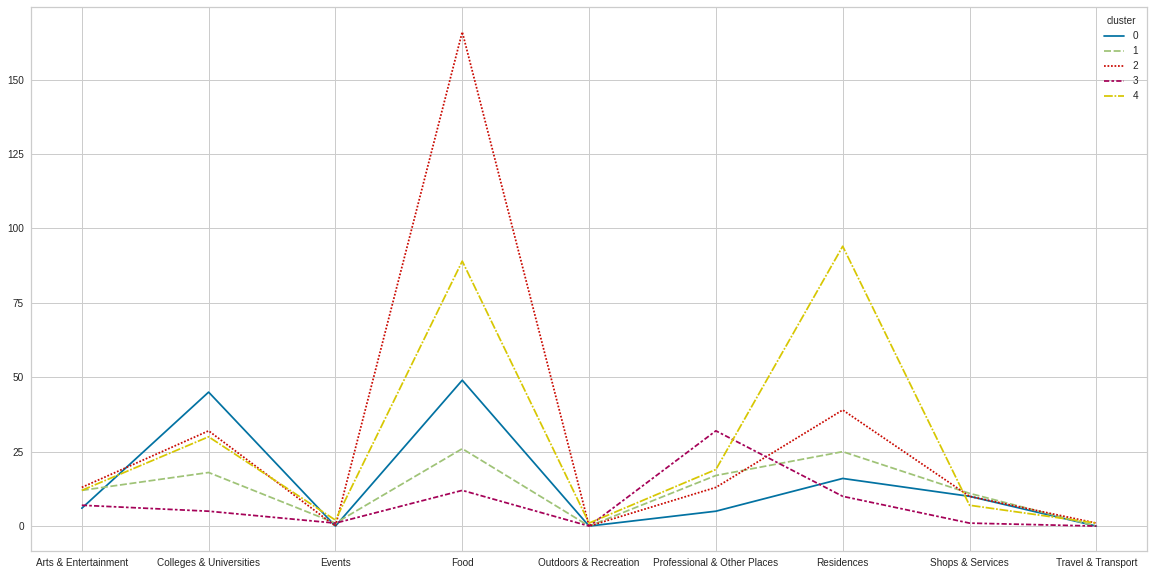

In [195]:
plt.figure(figsize=(20,10))
sns.lineplot(data=df_clusters_tot.T)
plt.show()

In [207]:
df_clusters_median = df.groupby('cluster').median()
df_clusters_median = df_clusters_median.sort_values('cluster', ascending=True)
df_clusters_median

,Arts & Entertainment,Colleges & Universities,Events,Food,Outdoors & Recreation,Professional & Other Places,Residences,Shops & Services,Travel & Transport
cluster,,,,,,,,,
0,0.0,3.0,0.0,4.0,0.0,0.0,1.0,1.0,0.0
1,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
2,0.0,1.0,0.0,7.5,0.0,0.0,1.0,0.0,0.0
3,0.5,1.0,0.0,1.0,0.0,3.5,1.0,0.0,0.0
4,0.0,1.0,0.0,4.0,0.0,1.0,4.0,0.0,0.0


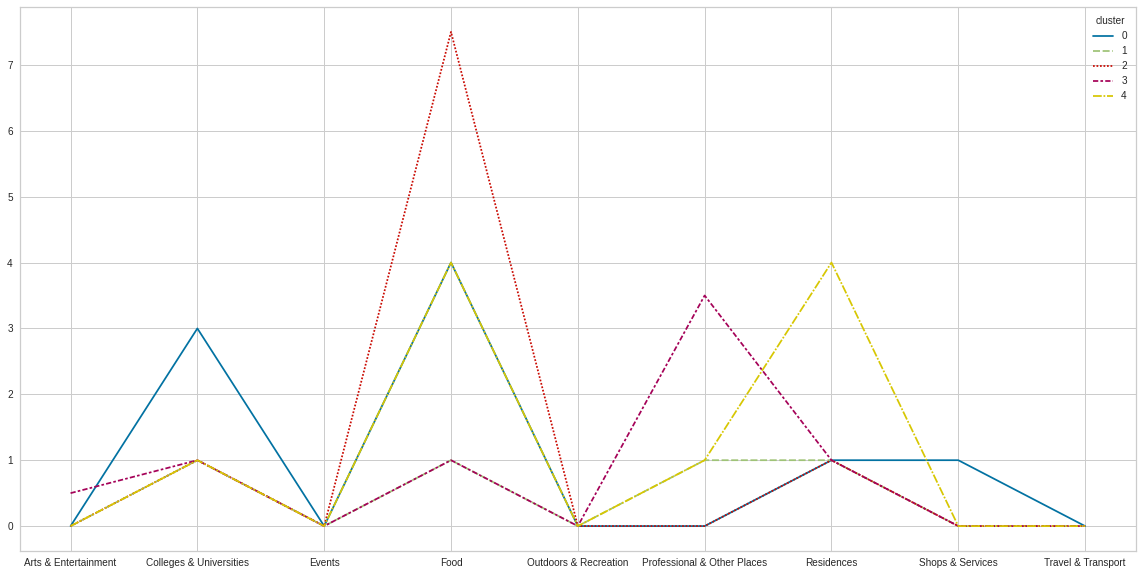

In [208]:
plt.figure(figsize=(20,10))
sns.lineplot(data=df_clusters_mean.T)
plt.show()

In [178]:
df_clusters = df.groupby('cluster').describe().sort_values('cluster', ascending=True)
df_clusters

Arts & Entertainment                                                \
                       count      mean       std  min  25%  50%   75%  max   
cluster                                                                      
0                       13.0  0.461538  0.660225  0.0  0.0  0.0  1.00  2.0   
1                       25.0  0.480000  0.714143  0.0  0.0  0.0  1.00  2.0   
2                       22.0  0.590909  0.854071  0.0  0.0  0.0  1.00  3.0   
3                        8.0  0.875000  1.125992  0.0  0.0  0.5  1.25  3.0   
4                       25.0  0.480000  0.714143  0.0  0.0  0.0  1.00  2.0   

        Colleges & Universities                                                \
                          count      mean       std  min   25%  50%  75%  max   
cluster                                                                         
0                          13.0  3.461538  1.506397  2.0  2.00  3.0  4.0  7.0   
1                          25.0  0.720000  0.613732  0.0  0.00  1.0  1.0  2.0   
2                          22.0  1.454545  1.471225  0.0  0.25  1.0  2.0  6.0   
3                           8.0  0.625000  0.517549  0.0  0.00  1.0  1.0  1.0   
4                          25.0  1.200000  1.000000  0.0  1.00  1.0  2.0  4.0   

        Events                                            Food            \
         count   mean       std  min  25%  50%  75%  max count      mean   
cluster                                                                    
0         13.0  0.000  0.000000  0.0  0.0  0.0  0.0  0.0  13.0  3.769231   
1         25.0  0.040  0.200000  0.0  0.0  0.0  0.0  1.0  25.0  1.040000   
2         22.0  0.000  0.000000  0.0  0.0  0.0  0.0  0.0  22.0  7.545455   
3          8.0  0.125  0.353553  0.0  0.0  0.0  0.0  1.0   8.0  1.500000   
4         25.0  0.080  0.276887  0.0  0.0  0.0  0.0  1.0  25.0  3.560000   

                                             Outdoors & Recreation             \
              std  min  25%  50%   75%   max                 count  mean  std   
cluster                                                                         
0        1.235168  2.0  3.0  4.0  5.00   5.0                  13.0  0.00  0.0   
1        0.934523  0.0  0.0  1.0  2.00   3.0                  25.0  0.00  0.0   
2        1.534594  5.0  6.0  7.5  8.75  11.0                  22.0  0.00  0.0   
3        1.069045  0.0  1.0  1.0  2.25   3.0                   8.0  0.00  0.0   
4        1.356466  1.0  3.0  4.0  5.00   6.0                  25.0  0.04  0.2   

                                 Professional & Other Places            \
         min  25%  50%  75%  max                       count      mean   
cluster                                                                  
0        0.0  0.0  0.0  0.0  0.0                        13.0  0.384615   
1        0.0  0.0  0.0  0.0  0.0                        25.0  0.680000   
2        0.0  0.0  0.0  0.0  0.0                        22.0  0.590909   
3        0.0  0.0  0.0  0.0  0.0                         8.0  4.000000   
4        0.0  0.0  0.0  0.0  1.0                        25.0  0.760000   

                                            Residences                      \
              std  min  25%  50%   75%  max      count      mean       std   
cluster                                                                      
0        0.650444  0.0  0.0  0.0  1.00  2.0       13.0  1.230769  0.599145   
1        0.748331  0.0  0.0  1.0  1.00  2.0       25.0  1.000000  0.957427   
2        1.053750  0.0  0.0  0.0  1.00  4.0       22.0  1.772727  1.445249   
3        1.414214  3.0  3.0  3.5  4.25  7.0        8.0  1.250000  1.281740   
4        0.778888  0.0  0.0  1.0  1.00  2.0       25.0  3.760000  1.362596   

                                  Shops & Services                           \
         min  25%  50%   75%  max            count      mean       std  min   
cluster                                                                       
0        0.0  1.0  1.

#2 Rascunho (ignorar)